# 1 - Importar Bibliotecas(deve ser rodado para gerar o CSV)

In [ ]:
# Standard libraries
import copy
import warnings
warnings.filterwarnings('ignore')

# Third-party libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tqdm
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from torch.utils.data import DataLoader, TensorDataset


#2 - Tratamento da entrada(deve ser rodado para gerar o CSV)

In [ ]:
# Download dataset
!gdown --fuzzy "https://drive.google.com/file/d/1i3YKPA5BqBYvOptIAXqC8X7lIyluf8bI/view?usp=sharing"
!gdown --fuzzy "https://drive.google.com/file/d/1eWweaJM4jemsM05cC-mmcDxPLRAtt0I_/view?usp=sharing"

Downloading...
From: https://drive.google.com/uc?id=1i3YKPA5BqBYvOptIAXqC8X7lIyluf8bI
To: /content/dados_treino_alunos.csv
100% 2.79M/2.79M [00:00<00:00, 293MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eWweaJM4jemsM05cC-mmcDxPLRAtt0I_
To: /content/dados_teste_competicao_features_POR_TIPO.csv
100% 2.81M/2.81M [00:00<00:00, 266MB/s]


In [ ]:
df = pd.read_csv('./dados_treino_alunos.csv')

df_comp = pd.read_csv('./dados_teste_competicao_features_POR_TIPO.csv')


In [ ]:
# Verificação do número de municípios
unique_cod_municipio = df['Cod_municipio'].nunique()
print(f"Number of unique Cod_municipio: {unique_cod_municipio}")

Number of unique Cod_municipio: 3924


In [ ]:
# Verificação de repetição de ano
unique_ano = df['Ano'].nunique()
print(f"Number of unique Ano: {unique_ano}")

Number of unique Ano: 1


In [ ]:
# Deletando features desnecessárias(Talvez incluir estado como one hot encoding)
df.drop(columns=['Nome_UF','Nome_Município', 'Tipo_de_VE', 'Ano'], inplace=True)

df_comp.drop(columns=['Nome_UF','Nome_Município', 'Tipo_de_VE', 'Ano'], inplace=True)

In [ ]:
# Somando a quantidade de veículos para cada município
df_grouped = df.groupby('Cod_municipio', as_index=False).agg({
    'Potencia_instalada_fotovoltaica': 'first',
    'Tarifa_eletrica': 'first',
    'Densidade_demo': 'first',
    'Frota': 'first',
    'Num_medio_salariosMin': 'first',
    'Num_empregados': 'first',
    'Num_empresas': 'first',
    'PIB': 'first',
    'Populacao': 'first',
    'Area': 'first',
    'IDH_educacao': 'first',
    'IDH_saude': 'first',
    'IDH_renda': 'first',
    'Educacao_superior': 'first',
    'Irradiancia': 'first',
    'Num_familias': 'first',
    'Verticalizacao_cidades': 'first',
    'Familias_area_rural': 'first',
    'Casas_proprias': 'first',
    'Casas_alugadas': 'first',
    'Residentes_por_familia': 'first',
    'Familias_mais_3_salarios': 'first',
    'Qtd. Veículos': 'sum'
})

df_grouped_comp = df_comp.groupby('Cod_municipio', as_index=False).agg({
    'Potencia_instalada_fotovoltaica': 'first',
    'Tarifa_eletrica': 'first',
    'Densidade_demo': 'first',
    'Frota': 'first',
    'Num_medio_salariosMin': 'first',
    'Num_empregados': 'first',
    'Num_empresas': 'first',
    'PIB': 'first',
    'Populacao': 'first',
    'Area': 'first',
    'IDH_educacao': 'first',
    'IDH_saude': 'first',
    'IDH_renda': 'first',
    'Educacao_superior': 'first',
    'Irradiancia': 'first',
    'Num_familias': 'first',
    'Verticalizacao_cidades': 'first',
    'Familias_area_rural': 'first',
    'Casas_proprias': 'first',
    'Casas_alugadas': 'first',
    'Residentes_por_familia': 'first',
    'Familias_mais_3_salarios': 'first',
})

print(f"Original rows: {len(df)}, Grouped rows: {len(df_grouped)}")
df_grouped

Original rows: 12006, Grouped rows: 3924


,Cod_municipio,Potencia_instalada_fotovoltaica,Tarifa_eletrica,Densidade_demo,Frota,Num_medio_salariosMin,Num_empregados,Num_empresas,PIB,Populacao,...,Educacao_superior,Irradiancia,Num_familias,Verticalizacao_cidades,Familias_area_rural,Casas_proprias,Casas_alugadas,Residentes_por_familia,Familias_mais_3_salarios,Qtd. Veículos
0,1100015,3467.06,686.555813,3.04,16100.0,2.1,3706,848,21968.76,21494.0,...,0.036,4635.0,7695.0,0.001689,0.375049,0.697076,0.106823,2.79,0.030669,5
1,1100023,28751.08,686.555813,21.88,82721.0,2.0,24810,4533,22495.49,96833.0,...,0.039,4494.0,34768.0,0.062069,0.126754,0.515905,0.182984,2.77,0.053325,131
2,1100031,1322.32,686.555813,4.07,4039.0,1.9,805,199,27082.16,5351.0,...,0.038,4795.0,1967.0,0.001525,0.456533,0.764616,0.075750,2.72,0.030503,2
3,1100049,25024.72,686.555813,22.91,75559.0,1.9,23243,4045,25385.70,86887.0,...,0.047,4622.0,31917.0,0.078986,0.162860,0.507660,0.167309,2.71,0.052668,66
4,1100056,4588.86,686.555813,5.71,13012.0,2.0,3556,773,29139.65,15890.0,...,0.048,4767.0,5873.0,0.009705,0.106419,0.674102,0.132641,2.69,0.044951,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919,5221908,548.60,853.737962,7.18,2286.0,1.6,439,124,17234.77,3716.0,...,0.026,5280.0,1553.0,0.000000,0.396008,0.504185,0.142949,2.39,0.056021,1
3920,5222005,2271.46,853.737962,15.68,11355.0,2.2,3442,762,31496.17,14956.0,...,0.034,5306.0,5499.0,0.009093,0.216221,0.485543,0.145481,2.71,0.052737,17
3921,5222054,898.76,853.737962,11.95,5797.0,2.1,2500,339,36330.36,8768.0,...,0.031,5299.0,3144.0,0.001908,0.098601,0.451972,0.184160,2.76,0.044529,1
3922,5222302,630.70,853.737962,2.67,1132.0,2.0,1533,176,27844.67,5815.0,...,0.015,5332.0,2180.0,0.000459,0.410550,0.425229,0.066972,2.66,0.017890,1


In [ ]:
# Convertendo todos os valores para float
df_grouped_remv = df_grouped
for col in df_grouped.columns:
    df_grouped_remv[col] = pd.to_numeric(df_grouped[col]).astype('float64')

X = df_grouped_remv.drop(columns=['Cod_municipio', 'Qtd. Veículos'])
y = df_grouped_remv['Qtd. Veículos']

# Embaralhando e separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)


# Normalizando os dados
x_scaler = StandardScaler()
# O fit faz o cálculo da média e desvio para normalizar
X_train_norm = x_scaler.fit_transform(X_train.values)
# Usar a média e desvio já calculados para evitar data leakage
X_test_norm = x_scaler.transform(X_test.values)

# Normalizando o Y
# Deve se considerar que quanto maior os valores de y
# Maior vai ser a loss e logo maior vai ser a atualização dos pesos
# Resultando em explosão de gradientes
y_scaler = StandardScaler()
y_train_norm = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_norm = y_scaler.transform(y_test.values.reshape(-1, 1))

#y_pred_original = y_scaler.inverse_transform(
#    y_pred.cpu().numpy().reshape(-1, 1))

# Verificando valores NULL ou NAN
print("Has Null:", df_grouped_remv.isnull().any().any())
print("Has NaN:", df_grouped_remv.isna().any().any())

# Verificando quantidade de dados
print('Train data:', len(X_train))
print('Test data:', len(X_test))

Has Null: False
Has NaN: False
Train data: 3139
Test data: 785


# 3 - Modelos(deve ser rodado para gerar o CSV)


In [ ]:
class LinearMostSimple(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(22, 18)
        self.norm = nn.BatchNorm1d(18)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.1)
        self.l2 = nn.Linear(18, 12)
        self.norm1 = nn.BatchNorm1d(12)
        self.relu1 = nn.ReLU()
        self.l3 = nn.Linear(12, 6)
        self.norm2 = nn.BatchNorm1d(6)
        self.relu2 = nn.ReLU()
        self.l4 = nn.Linear(6, 1)

        # Inicialização
        nn.init.xavier_uniform_(self.l1.weight)
        nn.init.xavier_uniform_(self.l2.weight)
        nn.init.xavier_uniform_(self.l3.weight)
        nn.init.xavier_uniform_(self.l4.weight)

    def forward(self, x):
        x = self.l1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.l2(x)
        #x = self.norm1(x)
        x = self.relu1(x)
        x = self.drop(x)
        x = self.l3(x)
        #x = self.norm2(x)
        x = self.relu2(x)
        x = self.l4(x)

        return x

In [ ]:
# Cria o modelo e manda para a GPU
model = LinearMostSimple().to('cuda')
# Treina mais rápido se compilado
model = torch.compile(model)

# Loss MSE
loss_fn = torch.nn.MSELoss()#reduction='mean')

#4 - Treinamento DNN
*   Nem sempre o melhor modelo é conseguido, por isso deixei salvo os pesos do melhor modelo que eu consegui.


In [ ]:
# Transformando os dados para tensores
X_train_tensor_norm = torch.tensor(X_train_norm,
                                   dtype=torch.float32).to('cuda')
y_train_tensor_norm = torch.tensor(
    y_train_norm,
    dtype=torch.float32).reshape(-1, 1).to('cuda')
X_test_tensor_norm = torch.tensor(X_test_norm,
                                  dtype=torch.float32).to('cuda')
y_test_tensor_norm = torch.tensor(y_test_norm,
                                  dtype=torch.float32).reshape(-1, 1).to('cuda')

# Dados não torch não normalizados
X_train_tensor = torch.tensor(X_train.values,
                              dtype=torch.float32).to('cuda')
y_train_tensor = torch.tensor(y_train.values,
                              dtype=torch.float32).reshape(-1, 1).to('cuda')
X_test_tensor = torch.tensor(X_test.values,
                             dtype=torch.float32).to('cuda')
y_test_tensor = torch.tensor(y_test.values,
                             dtype=torch.float32).reshape(-1, 1).to('cuda')

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

X_train_tensor = X_train_tensor_norm
y_train_tensor = y_train_tensor
X_test_tensor = X_test_tensor_norm
y_test_tensor = y_test_tensor

# Dataset e loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=0)

# Optimizer com weight decay para regularização adicional
optimizer = torch.optim.Adam(model.parameters(),
                           lr=1e-2,
                           weight_decay=1e-5)  # L2 regularization

# Scheduler mais sofisticado
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       patience=40,  # Aumentado
                                                       factor=0.7,   # Redução mais suave
                                                       min_lr=1e-6,
                                                       verbose=True)

# Tracking melhorado
history = {'train_loss': [], 'test_loss': [], 'test_r2': [], 'lr': []}
best_test_loss = float('inf')
best_weights = None
max_patience = 100  # Aumentado baseado na sua análise
patience = 0
n_epochs = 1000

print(f"Starting training for {n_epochs} epochs...")
print(f"Early stopping patience: {max_patience}")
print(f"Initial learning rate: {optimizer.param_groups[0]['lr']}")

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    # Training phase
    model.train()
    epoch_train_losses = []

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()

        # Gradient clipping para estabilidade
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        epoch_train_losses.append(loss.item())

    # Média das losses do epoch
    epoch_train_loss = np.mean(epoch_train_losses)
    train_rmse = np.sqrt(epoch_train_loss)

    print(f"Train Loss MSE: {epoch_train_loss:.4f}")
    print(f"Train Loss RMSE: {train_rmse:.4f}")

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor.to(device))
        test_loss = loss_fn(y_pred, y_test_tensor.to(device)).item()

        test_rmse = np.sqrt(test_loss)

        # R² calculation
        ss_res = torch.sum((y_test_tensor.to(device) - y_pred) ** 2)
        ss_tot = torch.sum((y_test_tensor.to(device) - torch.mean(y_test_tensor.to(device))) ** 2)
        test_r2 = (1 - ss_res / ss_tot).item()

    # Learning rate scheduling
    current_lr = optimizer.param_groups[0]['lr']
    #scheduler.step(test_loss)
    new_lr = optimizer.param_groups[0]['lr']

    # Armazenar histórico
    history['train_loss'].append(epoch_train_loss)
    history['test_loss'].append(test_loss)
    history['test_r2'].append(test_r2)
    history['lr'].append(current_lr)

    print(f"Test Loss MSE: {test_loss:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")

    if new_lr != current_lr:
        print(f"Learning rate reduced to: {new_lr:.2e}")

    # Early stopping com melhor modelo
    if test_loss < best_test_loss:
        improvement = best_test_loss - test_loss
        best_test_loss = test_loss
        best_weights = model.state_dict().copy()
        save_info_best_model = {
            'epoch': epoch,
            'train_loss': epoch_train_loss,
            'train_rmse': train_rmse,
            'test_loss': test_loss,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'learning_rate': current_lr
        }
        patience = 0
        print(f"✓ New best model! Improvement: {improvement:.4f}")
    else:
        patience += 1
        print(f"Patience: {patience}/{max_patience}")

        if patience >= max_patience and test_loss < 80:
            print(f"\nEarly stopping at epoch {epoch+1}!")
            print(f"Best test loss: {best_test_loss:.4f}")
            break

# Carregar o melhor modelo
model.load_state_dict(best_weights)
print(f"\nTraining completed!")
print(f"Best model from epoch {save_info_best_model['epoch']+1}")
print(f"Best test R²: {save_info_best_model['test_r2']:.4f}")
print(f"Best test RMSE: {save_info_best_model['test_rmse']:.4f}")

# Salvar informações do melhor modelo
print("\nBest model info:")
print(save_info_best_model)

Streaming output truncated to the last 5000 lines.
Train Loss RMSE: 195.2096
Test Loss MSE: 112876.4531
Test RMSE: 335.9709
Test R²: 0.9099
Learning Rate: 1.00e-02
Patience: 193/100

Epoch 447/1000
Train Loss MSE: 55663.3637
Train Loss RMSE: 235.9308
Test Loss MSE: 275731.5625
Test RMSE: 525.1015
Test R²: 0.7800
Learning Rate: 1.00e-02
Patience: 194/100

Epoch 448/1000
Train Loss MSE: 88632.0587
Train Loss RMSE: 297.7114
Test Loss MSE: 140080.9375
Test RMSE: 374.2739
Test R²: 0.8882
Learning Rate: 1.00e-02
Patience: 195/100

Epoch 449/1000
Train Loss MSE: 68026.4123
Train Loss RMSE: 260.8187
Test Loss MSE: 507585.1562
Test RMSE: 712.4501
Test R²: 0.5949
Learning Rate: 1.00e-02
Patience: 196/100

Epoch 450/1000
Train Loss MSE: 339493.8364
Train Loss RMSE: 582.6610
Test Loss MSE: 80342.4297
Test RMSE: 283.4474
Test R²: 0.9359
Learning Rate: 1.00e-02
Patience: 197/100

Epoch 451/1000
Train Loss MSE: 76134.4718
Train Loss RMSE: 275.9248
Test Loss MSE: 10696.9707
Test RMSE: 103.4262
Test R²

In [ ]:
save_info_best_model

{'epoch': 956,
 'train_loss': np.float64(30295.784974791786),
 'train_rmse': np.float64(174.05684409063548),
 'test_loss': 5176.7421875,
 'test_rmse': np.float64(71.94958087091265),
 'test_r2': 0.9958686828613281,
 'learning_rate': 0.01}

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
# i want to know how good is the model in the test dataset
# load weigths in the model
model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_state_dict.pth'))
model.eval()

Mounted at /content/drive


OptimizedModule(
  (_orig_mod): LinearMostSimple(
    (l1): Linear(in_features=22, out_features=18, bias=True)
    (norm): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (drop): Dropout(p=0.1, inplace=False)
    (l2): Linear(in_features=18, out_features=12, bias=True)
    (norm1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (l3): Linear(in_features=12, out_features=6, bias=True)
    (norm2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (l4): Linear(in_features=6, out_features=1, bias=True)
  )
)

#5 - Comparação e treinamento entre modelos não DNN


*   Os modelos em holdout foram treinados da mesma forma que MLP


In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd

class RegressionComparison:
    def __init__(self, X, y, test_size=0.2, random_state=42, normalize=False):
        """
        Inicializa a comparação de algoritmos de regressão

        Parameters:
        X: features (já preparadas e normalizadas)
        y: target variable
        test_size: proporção para teste
        random_state: seed para reproducibilidade
        """
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state
        self.results = {}
        self.grid_search_results = {}

        # Split inicial
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Verifica se quer normalizar
        if normalize:
            self.normalize_data()

    def normalize_data(self):
        """Normaliza os dados"""
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)

    def rmse(self, y_true, y_pred):
        """Calcula RMSE"""
        return np.sqrt(mean_squared_error(y_true, y_pred))

    def mse(self, y_true, y_pred):
        """Calcula MSE"""
        return mean_squared_error(y_true, y_pred)

    def holdout_simple(self):
        """Holdout Simples - treina e testa uma vez"""
        print("=== SIMPLE HOLDOUT ===")

        models = {
            'Linear Regression': LinearRegression(),
            'Decision Tree': DecisionTreeRegressor(
                random_state=self.random_state),
            'Random Forest': RandomForestRegressor(
                n_estimators=100,
                random_state=self.random_state),
            'K-NN': KNeighborsRegressor(n_neighbors=5),
            'SVR': SVR(kernel='rbf', C=1.0),
            'XGBoost': xgb.XGBRegressor(
                random_state=self.random_state,
                verbosity=0)
        }

        holdout_results = {}

        for name, model in models.items():
            # Treinar
            model.fit(self.X_train, self.y_train)

            # Predizer
            y_pred = model.predict(self.X_test)

            # Métricas
            rmse = self.rmse(self.y_test, y_pred)
            mse = self.mse(self.y_test, y_pred)
            r2 = r2_score(self.y_test, y_pred)

            holdout_results[name] = {
                'RMSE': rmse,
                'MSE': mse,
                'R²': r2
            }

            print(f"{name:20} - RMSE: {rmse:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

        self.results['Holdout'] = holdout_results
        return holdout_results

    def holdout_optimized_models(self):
        """Holdout com modelos otimizados do Grid Search"""
        if 'Grid Search' not in self.results:
            print("Grid Search has not been executed yet. Run grid_search_cv() first.")
            return None

        print("\n=== HOLDOUT WITH OPTIMIZED MODELS ===")

        holdout_optimized_results = {}

        for name, grid_result in self.grid_search_results.items():
            # Pegar o melhor modelo do Grid Search
            best_model = grid_result['best_model']

            # O modelo já foi treinado no Grid Search, mas vamos retreinar
            # no conjunto de treino completo para garantir consistência
            best_model.fit(self.X_train, self.y_train)

            # Predizer para o conjunto de treino
            y_train_pred = best_model.predict(self.X_train)
            # Predizer no conjunto de teste
            y_pred = best_model.predict(self.X_test)

            # Calcular métricas
            rmse_train = self.rmse(self.y_train, y_train_pred)
            rmse = self.rmse(self.y_test, y_pred)
            mse = self.mse(self.y_test, y_pred)
            r2 = r2_score(self.y_test, y_pred)

            holdout_optimized_results[name] = {
                'RMSE_train': rmse_train,
                'RMSE': rmse,
                'MSE': mse,
                'R²': r2,
                'best_params': grid_result['best_params']
            }

            print(f"RMSE Train: {rmse_train:4f} - RMSE Test: {rmse:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")
            print(f"{'':20}   Best params: {grid_result['best_params']}")

        self.results['Holdout Optimized'] = holdout_optimized_results
        return holdout_optimized_results

    def grid_search_cv(self, k=5, scoring='neg_mean_squared_error', n_jobs=-1):
        """Grid Search Cross-Validation para otimização de hiperparâmetros"""
        print(f"\n=== GRID SEARCH {k}-FOLD CROSS-VALIDATION ===")

        # Definição dos modelos e seus hiperparâmetros para otimização
        models_and_params = {
            'Linear Regression': {
                'model': LinearRegression(),
                'params': {
                    # fit_intercept: Se True, calcula o termo de intercepto (bias)
                    # Se False, assume que os dados já estão centralizados
                    'fit_intercept': [True, False]
                }
            },
            'Decision Tree': {
                'model': DecisionTreeRegressor(random_state=self.random_state),
                'params': {
                    # max_depth: Profundidade máxima da árvore
                    # None = sem limite (pode causar overfitting)
                    # Valores baixos = underfitting, valores altos = overfitting
                    'max_depth': [5, 10, None],

                    # min_samples_split: Número mínimo de amostras para dividir um nó interno
                    # Valores altos = árvore mais conservadora (menos overfitting)
                    # Valores baixos = árvore mais complexa (mais overfitting)
                    'min_samples_split': [2, 10],

                    # min_samples_leaf: Número mínimo de amostras em uma folha
                    # Controla o tamanho mínimo das folhas da árvore
                    # Valores altos = generalização melhor
                    'min_samples_leaf': [1, 4],

                    # criterion: Função para medir a qualidade de uma divisão
                    # squared_error: usa variância para regressão
                    'criterion': ['squared_error']
                }
            },
            'Random Forest': {
                'model': RandomForestRegressor(random_state=self.random_state),
                'params': {
                    # n_estimators: Número de árvores na floresta
                    # Mais árvores = melhor performance mas mais lento
                    # Retornos diminuem após certo ponto
                    'n_estimators': [50, 100, 200],

                    # max_depth: Profundidade máxima de cada árvore
                    # None = nós são expandidos até que folhas sejam puras
                    # Controla overfitting das árvores individuais
                    'max_depth': [5, None],

                    # min_samples_split: Mínimo de amostras para dividir nó interno
                    # Previne divisões com poucas amostras
                    'min_samples_split': [1, 2, 10],

                    # max_features: Número de features consideradas para melhor divisão
                    # sqrt: raiz quadrada do total de features
                    # None: usa todas as features
                    # Controla aleatoriedade e generalização
                    'max_features': ['sqrt', None]
                }
            },
            'K-NN': {
                'model': KNeighborsRegressor(),
                'params': {
                    # n_neighbors: Número de vizinhos mais próximos
                    # Valores baixos = mais sensível a ruído (overfitting)
                    # Valores altos = decisão mais suave (underfitting)
                    'n_neighbors': [3, 5, 7],

                    # weights: Função de peso para vizinhos
                    # uniform: todos os vizinhos têm peso igual
                    # distance: peso inversamente proporcional à distância
                    'weights': ['uniform', 'distance'],

                    # algorithm: Algoritmo para computar vizinhos mais próximos
                    # auto: tenta decidir automaticamente o melhor algoritmo
                    'algorithm': ['auto'],

                    # p: Parâmetro para métrica de distância Minkowski
                    # p=1: distância Manhattan, p=2: distância Euclidiana
                    'p': [2]
                }
            },
            'SVR': {
                'model': SVR(),
                'params': {
                    # kernel: Especifica tipo de kernel usado no algoritmo
                    # rbf: Radial Basis Function - bom para dados não-lineares
                    # linear: para relações lineares, poly: polinomial
                    'kernel': ['linear'],

                    # C: Parâmetro de regularização
                    # Valores baixos = mais regularização (underfitting)
                    # Valores altos = menos regularização (overfitting)
                    'C': [100],

                    # gamma: Coeficiente do kernel para rbf, poly e sigmoid
                    # scale: 1 / (n_features * X.var())
                    # Valores altos = influência de cada exemplo de treino é baixa
                    'gamma': [0.1],

                    # epsilon: Especifica epsilon-tube dentro do qual não há penalidade
                    # Controla o número de support vectors
                    # Valores maiores = modelo mais simples
                    'epsilon': [0.2]
                }
            },
            'XGBoost': {
                'model': xgb.XGBRegressor(random_state=self.random_state, verbosity=0),
                'params': {
                    # n_estimators: Número de árvores de gradient boosting
                    # Mais árvores = melhor performance mas risco de overfitting
                    'n_estimators': [50, 100],

                    # max_depth: Profundidade máxima de cada árvore
                    # Controla complexidade do modelo
                    # Valores altos podem causar overfitting
                    'max_depth': [3, 5],

                    # learning_rate: Taxa de aprendizado do boosting
                    # Valores baixos = treinamento mais lento mas melhor generalização
                    # Valores altos = treinamento mais rápido mas risco overfitting
                    'learning_rate': [0.01, 0.1, 0.2],

                    # subsample: Fração de amostras usadas para treinar cada árvore
                    # Valores < 1.0 = stochastic gradient boosting
                    # Previne overfitting introduzindo aleatoriedade
                    'subsample': [0.9],

                    # colsample_bytree: Fração de features usadas para cada árvore
                    # Controla aleatoriedade e previne overfitting
                    # Valores baixos = mais regularização
                    'colsample_bytree': [0.6, 0.9]
                }
            }
        }

        grid_results = {}

        for name, model_info in models_and_params.items():
            # Calcular número de combinações de hiperparâmetros
            param_combinations = 1
            for param_values in model_info['params'].values():
                param_combinations *= len(param_values)

            total_fits = param_combinations * k
            print(f"\nOptimizing {name}... ({param_combinations} combinations × {k}-fold = {total_fits} fits)")

            # Grid Search com validação cruzada
            grid_search = GridSearchCV(
                estimator=model_info['model'],
                param_grid=model_info['params'],
                cv=k,
                scoring=scoring,  # neg_mean_squared_error para minimizar MSE
                n_jobs=n_jobs,   # -1 usa todos os processadores disponíveis
                verbose=1        # Mostra progresso
            )

            # Treinar no conjunto de treino
            grid_search.fit(self.X_train, self.y_train)

            # Melhor modelo encontrado
            best_model = grid_search.best_estimator_

            # Predições no conjunto de teste
            y_pred = best_model.predict(self.X_test)

            # Calcular métricas no conjunto de teste
            rmse = self.rmse(self.y_test, y_pred)
            mse = self.mse(self.y_test, y_pred)
            r2 = r2_score(self.y_test, y_pred)

            # Armazenar resultados
            grid_results[name] = {
                'best_params': grid_search.best_params_,
                'best_cv_score': -grid_search.best_score_,  # Converter de neg_MSE para MSE
                'test_RMSE': rmse,
                'test_MSE': mse,
                'test_R²': r2,
                'cv_RMSE': np.sqrt(-grid_search.best_score_),  # RMSE da validação cruzada
                'best_model': best_model
            }

            print(f"{name:20} - CV RMSE: {np.sqrt(-grid_search.best_score_):.4f}, "
                f"Test RMSE: {rmse:.4f}, Test R²: {r2:.4f}")
            print(f"{'':20}   Best parameters: {grid_search.best_params_}")

        self.results['Grid Search'] = grid_results
        self.grid_search_results = grid_results
        return grid_results

    def run_all_experiments(self, include_grid_search=True, include_holdout_optimized=True):
        """Executa todos os experimentos de comparação"""
        print("REGRESSION ALGORITHMS COMPARISON")
        print("="*60)
        print(f"Dataset shape: X={self.X.shape}, y={self.y.shape}")
        print("="*60)

        # Holdout simples com parâmetros default
        self.holdout_simple()

        if include_grid_search:
            # Grid Search para otimização de hiperparâmetros
            self.grid_search_cv(k=10)

            if include_holdout_optimized:
                # Holdout com modelos otimizados
                self.holdout_optimized_models()

        return self.results

    def get_optimized_models(self):
        """Retorna os modelos otimizados do Grid Search"""
        if 'Grid Search' not in self.results:
            print("Grid Search has not been executed yet. Run grid_search_cv() first.")
            return None

        optimized_models = {}
        for name, result in self.grid_search_results.items():
            optimized_models[name] = result['best_model']

        return optimized_models

    def compare_holdout_methods(self):
        """Compara os resultados do holdout simples vs holdout otimizado"""
        if 'Holdout' not in self.results or 'Holdout Optimized' not in self.results:
            print("Both holdout_simple() and holdout_optimized_models() must be executed first")
            return

        print("\n" + "="*80)
        print("COMPARISON: SIMPLE HOLDOUT vs OPTIMIZED HOLDOUT")
        print("="*80)

        # Criar dados para comparação
        comparison_data = []

        for model_name in self.results['Holdout'].keys():
            if model_name in self.results['Holdout Optimized']:
                simple_rmse = self.results['Holdout'][model_name]['RMSE']
                optimized_rmse = self.results['Holdout Optimized'][model_name]['RMSE']
                improvement = ((simple_rmse - optimized_rmse) / simple_rmse) * 100

                comparison_data.append({
                    'Model': model_name,
                    'Simple RMSE': simple_rmse,
                    'Optimized RMSE': optimized_rmse,
                    'Improvement (%)': improvement,
                    'Simple R²': self.results['Holdout'][model_name]['R²'],
                    'Optimized R²': self.results['Holdout Optimized'][model_name]['R²']
                })

        # Mostrar comparação detalhada
        for data in comparison_data:
            print(f"\n{data['Model']}:")
            print(f"  Simple RMSE:     {data['Simple RMSE']:.4f}")
            print(f"  Optimized RMSE:  {data['Optimized RMSE']:.4f}")
            print(f"  Improvement:     {data['Improvement (%)']:+.2f}%")
            print(f"  Simple R²:       {data['Simple R²']:.4f}")
            print(f"  Optimized R²:    {data['Optimized R²']:.4f}")

        # Encontrar melhores modelos
        best_simple = min(comparison_data, key=lambda x: x['Simple RMSE'])
        best_optimized = min(comparison_data, key=lambda x: x['Optimized RMSE'])

        print(f"\n{'='*50}")
        print(f"BEST SIMPLE MODEL: {best_simple['Model']} (RMSE: {best_simple['Simple RMSE']:.4f})")
        print(f"BEST OPTIMIZED MODEL: {best_optimized['Model']} (RMSE: {best_optimized['Optimized RMSE']:.4f})")

        return comparison_data

    def compare_methods_summary(self):
        """Compara os resultados de todos os métodos em uma tabela resumo"""
        if not self.results:
            print("No experiments have been executed yet.")
            return

        print("\n" + "="*80)
        print("COMPARATIVE SUMMARY - BEST MODELS BY METHOD")
        print("="*80)

        best_models = self.get_best_models()

        for method, info in best_models.items():
            print(f"\n{method}:")
            print(f"  Best model: {info['model']}")
            print(f"  RMSE: {info['RMSE']:.4f}")
            print(f"  MSE: {info['MSE']:.4f}")
            print(f"  R²: {info['R²']:.4f}")
            if 'best_params' in info:
                print(f"  Parameters: {info['best_params']}")

    def get_best_models(self):
        """Retorna o melhor modelo de cada método baseado no menor RMSE"""
        best_models = {}

        for method, results in self.results.items():
            if method == 'Grid Search':
                continue  # Grid Search é analisado através do Holdout Optimized

            # Encontrar modelo com menor RMSE
            best_model_name = min(results.keys(), key=lambda x: results[x]['RMSE'])
            best_result = results[best_model_name]

            best_models[method] = {
                'model': best_model_name,
                'RMSE': best_result['RMSE'],
                'MSE': best_result['MSE'],
                'R²': best_result['R²']
            }

            # Adicionar parâmetros otimizados se disponível
            if 'best_params' in best_result:
                best_models[method]['best_params'] = best_result['best_params']

        return best_models


In [ ]:
# 2. Inicialize a comparação
comparison = RegressionComparison(X, y, test_size=0.2, random_state=42)

# 3. Execute todos os experimentos
results = comparison.run_all_experiments(
    include_grid_search=True,
    include_holdout_optimized=True
)

# 4. Compare os métodos
comparison.compare_holdout_methods()

# 5. Resumo geral
comparison.compare_methods_summary()

REGRESSION ALGORITHMS COMPARISON
Dataset shape: X=(3924, 22), y=(3924,)
=== SIMPLE HOLDOUT ===
Linear Regression    - RMSE: 664.7464, MSE: 441887.7830, R²: 0.6473
Decision Tree        - RMSE: 428.7085, MSE: 183790.9771, R²: 0.8533
Random Forest        - RMSE: 601.4610, MSE: 361755.2818, R²: 0.7113
K-NN                 - RMSE: 759.1935, MSE: 576374.7719, R²: 0.5400
SVR                  - RMSE: 1114.9864, MSE: 1243194.6650, R²: 0.0079
XGBoost              - RMSE: 958.1072, MSE: 917969.4288, R²: 0.2674

=== GRID SEARCH 10-FOLD CROSS-VALIDATION ===

Optimizing Linear Regression... (2 combinations × 10-fold = 20 fits)
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Linear Regression    - CV RMSE: 195.4415, Test RMSE: 664.7779, Test R²: 0.6473
                       Best parameters: {'fit_intercept': False}

Optimizing Decision Tree... (12 combinations × 10-fold = 120 fits)
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Decision Tree        - CV RMSE: 945.9359, T

In [ ]:
# Neste caso apenas KNN e SVR vão ter alguma melhora pois temos os dados normalizados
# 2. Inicialize a comparação
comparison = RegressionComparison(X, y, test_size=0.2, random_state=42, normalize=True)

# 3. Execute todos os experimentos
results = comparison.run_all_experiments(
    include_grid_search=True,
    include_holdout_optimized=True
)

# 4. Compare os métodos
comparison.compare_holdout_methods()

# 5. Resumo geral
comparison.compare_methods_summary()

REGRESSION ALGORITHMS COMPARISON
Dataset shape: X=(3924, 22), y=(3924,)
=== SIMPLE HOLDOUT ===
Linear Regression    - RMSE: 664.7464, MSE: 441887.7830, R²: 0.6473
Decision Tree        - RMSE: 428.7139, MSE: 183795.6127, R²: 0.8533
Random Forest        - RMSE: 601.4489, MSE: 361740.7836, R²: 0.7113
K-NN                 - RMSE: 744.1072, MSE: 553695.4704, R²: 0.5581
SVR                  - RMSE: 1120.4306, MSE: 1255364.7565, R²: -0.0019
XGBoost              - RMSE: 958.1072, MSE: 917969.4288, R²: 0.2674

=== GRID SEARCH 10-FOLD CROSS-VALIDATION ===

Optimizing Linear Regression... (2 combinations × 10-fold = 20 fits)
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Linear Regression    - CV RMSE: 195.6026, Test RMSE: 664.7464, Test R²: 0.6473
                       Best parameters: {'fit_intercept': True}

Optimizing Decision Tree... (12 combinations × 10-fold = 120 fits)
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Decision Tree        - CV RMSE: 945.9358, T

In [ ]:
import matplotlib.pyplot as plt

# Função de visualização
def plot_dif(nome_modelo, y_pred, y_true):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true.values[:100], label='Real', marker='o', linestyle='-', alpha=0.7)
    plt.plot(y_pred[:100], label='Predito', marker='x', linestyle='--', alpha=0.7)
    plt.title(f"{nome_modelo} Real vs. Predito (100 amostras)")
    plt.xlabel("Índice da Amostra")
    plt.ylabel("Qtd. Veículos")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

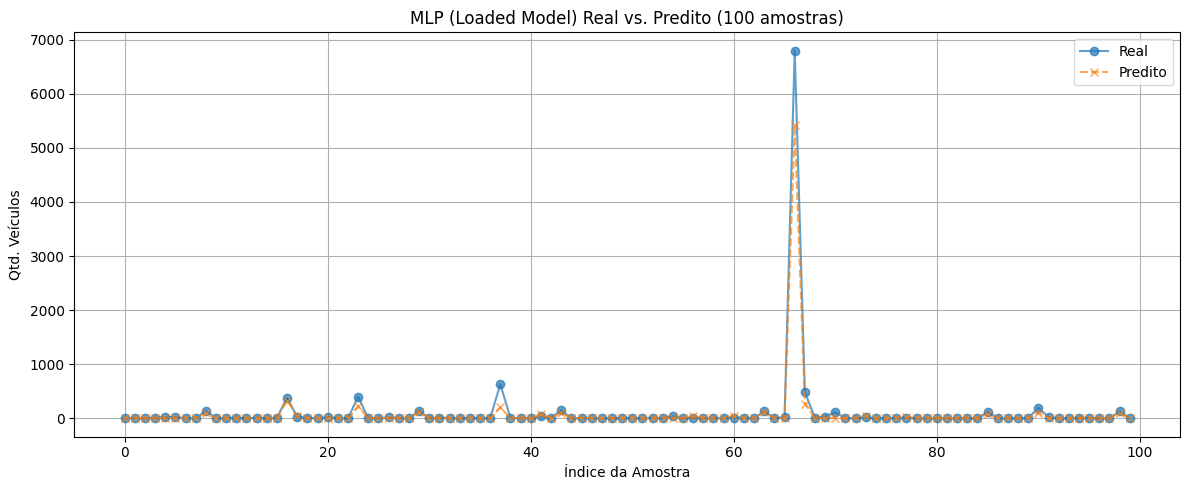

,Qtd. Veículos (Real),Qtd. Veículos (Predito)
3649,4.0,4.709765
463,7.0,4.228819
2764,2.0,5.988323
2384,15.0,7.932024
2091,20.0,9.119263


,Média,Mediana,Moda,Mínimo,Máximo
Qtd. Veículos (Real),93.388535,4.000000,1.000000,1.000000,30241.000000
Qtd. Veículos (Predito),70.152779,6.579868,17.449841,0.638062,24258.685547


In [ ]:
# Make predictions with the loaded MLP model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred_mlp = model(X_test_tensor_norm).cpu().numpy()

# Flatten the predictions to match the shape of y_test
y_pred_mlp = y_pred_mlp.flatten()

# Plot the difference for the MLP model
plot_dif("MLP (Loaded Model)", y_pred_mlp, y_test)

# Create the comparison DataFrame
df_comparacao = pd.DataFrame({
    'Qtd. Veículos (Real)': y_test,
    'Qtd. Veículos (Predito)': y_pred_mlp
})

# Display the comparison DataFrame
display(df_comparacao.head())

# Calculate descriptive statistics
numeric_cols = ['Qtd. Veículos (Real)', 'Qtd. Veículos (Predito)']
medidas_tendencia = pd.DataFrame(index=numeric_cols)

for col in numeric_cols:
    medidas_tendencia.loc[col, 'Média'] = df_comparacao[col].mean()
    medidas_tendencia.loc[col, 'Mediana'] = df_comparacao[col].median()
    medidas_tendencia.loc[col, 'Moda'] = df_comparacao[col].mode().iloc[0] if not df_comparacao[col].mode().empty else None
    medidas_tendencia.loc[col, 'Mínimo'] = df_comparacao[col].min()
    medidas_tendencia.loc[col, 'Máximo'] = df_comparacao[col].max()

display(medidas_tendencia)

#6 - Criando o arquivo CSV(deve ser rodado para gerar o CSV)


In [ ]:
# Download e carregamento do melhor modelo
!gdown --fuzzy "https://drive.google.com/file/d/1Msj-jml3WnTtk4QIi7uyT85EZuzOk7ke/view?usp=sharing"

# Melhor modelo
model.load_state_dict(torch.load('/content/best_model_state_dict.pth'))
model.eval()

Downloading...
From: https://drive.google.com/uc?id=1Msj-jml3WnTtk4QIi7uyT85EZuzOk7ke
To: /content/best_model_state_dict.pth
100% 11.1k/11.1k [00:00<00:00, 40.5MB/s]


OptimizedModule(
  (_orig_mod): LinearMostSimple(
    (l1): Linear(in_features=22, out_features=18, bias=True)
    (norm): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (drop): Dropout(p=0.1, inplace=False)
    (l2): Linear(in_features=18, out_features=12, bias=True)
    (norm1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (l3): Linear(in_features=12, out_features=6, bias=True)
    (norm2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (l4): Linear(in_features=6, out_features=1, bias=True)
  )
)

In [ ]:
df_grouped_comp_mod = df_grouped_comp.copy()

# Substitui o valores "#DIV/0!" por 0
df_grouped_comp_mod = df_grouped_comp_mod.replace('#DIV/0!', 0)

# Salvando o cod do municipio
df_grouped_comp_cod = df_grouped_comp_mod['Cod_municipio'].copy()

# Tratamento final dos dados
for col in df_grouped_comp_mod.columns:
    df_grouped_comp_mod[col] = pd.to_numeric(df_grouped_comp_mod[col]).astype('float64')

# Removendo a coluna cod municipio
df_grouped_comp_mod = df_grouped_comp_mod.drop(columns=['Cod_municipio'])

# Normalizar dados, a normalização considera apenas o dataset de treino
df_grouped_comp_norm = x_scaler.transform(df_grouped_comp_mod)

# Transformando para torch
df_grouped_comp_tensor = torch.tensor(df_grouped_comp_norm, dtype=torch.float32).to('cuda')

# Predizer com o modelo
y_pred_mlp = model(df_grouped_comp_tensor).cpu().detach().numpy()

# Criar dataframe com apenas o cod municipio e o valor predito
df_pred = pd.DataFrame({'Cod_municipio': df_grouped_comp_cod, 'Qtd_veiculos': y_pred_mlp.flatten()})

# Transformar cod municipio para int
df_pred['Cod_municipio'] = df_pred['Cod_municipio'].astype(int)

# Gerar arquivo csv
df_pred.to_csv('predicoes-modelo-dnn(parte-extra).csv', index=False)

W0626 23:01:51.087000 297 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
